## Authors

- Saranya Sundararajan (2577421)
- Bhuvanesh Kumar K(1844341)
- Santhossh J U (1982102)
- Mohammad Yaseen (2160066)
- Gowthaman A(1969311)


# Optimal Currency Arbitrage Opportunity Detection (QAOA + Qiskit)

This notebook solves the **Optimal Currency Arbitrage Opportunity Detection** challenge by formulating currency arbitrage as a **combinatorial optimization** problem and solving it with a **quantum-classical hybrid QAOA workflow**.

## Target output

- The best (most profitable) **trading cycle** such as:
  - `EUR → USD → CAD → EUR`
- The corresponding:
  - **gross return** (product of exchange rates along the cycle)
  - **log-return** (sum of log-rates)
- Quantum resource estimates:
  - **qubit count** (number of binary variables)
  - **QAOA circuit depth / size**

## Inputs

- **Exchange-rate data** is loaded from `Data/Data-sheet-New.csv` (matrix format; no hardcoded rates).
- Two user parameters drive the optimization:
  - `number_of_currencies` (N)
  - `trading_cycle_length` (L), where `L <= N`

## Approach (high-level)

1. Build a **QUBO** that encodes a length-`L` directed cycle through `N` currencies.
2. Convert QUBO → **Ising** (Pauli-Z Hamiltonian).
3. Run **QAOA** following the team-lead procedure (superposition → cost/mixer layers → sampling → classical tuning → winner selection).
4. Post-process the best bitstring into a human-readable cycle and profit.


## Introduction

**Currency arbitrage** exists when a sequence of currency conversions returns more than the starting amount (i.e., the product of rates along a directed cycle exceeds 1).

In this notebook, we:

- Model exchange rates as a **directed, weighted graph** derived from the **rate matrix**.
- Encode a length-`L` trading cycle using a **position-based binary encoding**.
- Formulate a **QUBO** that maximizes the cycle’s product of rates (equivalently maximizes log-return).
- Use **QAOA** to sample candidate cycles and then decode and validate them.

### Practical note

Real-world arbitrage profitability depends on spreads, fees, slippage, and execution latency. Later sections include a simple **per-trade fee sensitivity** calculation to illustrate this effect.

## Workflow overview

![Workflow Diagram](https://i.ibb.co/N27zvzS2/Screenshot-2025-11-07-110838.png)

This notebook follows a consistent pipeline:

1. **Load data (matrix) and build a graph**
   - Input is a square matrix `R` of exchange rates (row currency → column currency).
   - `R[i,j] = 0` is treated as “no direct conversion”.

2. **Formulate the optimization problem (QUBO)**
   - Binary variables `x[p,i]` indicate which currency `i` is placed at position `p` in a length-`L` cycle.
   - Objective maximizes total log-return along consecutive positions.
   - Penalties enforce:
     - exactly one currency per position
     - no repeated currencies
     - no invalid transitions

3. **Map QUBO to a quantum operator**
   - Convert QUBO into an **Ising Hamiltonian** usable by QAOA.

4. **Execute QAOA (simulation)**
   - Start in superposition
   - Apply cost (profit) and mixer layers
   - Sample bitstrings
   - Tune parameters with a classical optimizer
   - Pick the best feasible decoded cycle

5. **Post-process and validate**
   - Decode bitstrings → cycle
   - Compute gross return / log-return
   - Compare against small classical baselines (when feasible)

## Model setup (Rate matrix → QUBO)

### Decision variables (position-based)

- Let `p ∈ {0, …, L-1}` be a position in the cycle.
- Let `i ∈ {0, …, N-1}` index currencies.

Binary variable:

- `x[p,i] = 1` means currency `i` is placed at position `p`.

Total number of variables (and qubits):

- `N × L`

### Objective

A candidate cycle `(c_0 → c_1 → ... → c_{L-1} → c_0)` has gross return:

- `Π_{p=0..L-1} R[c_p, c_{(p+1) mod L}]`

We maximize this by minimizing the negative log-return:

- `min Σ_p -log(R[c_p, c_{p+1}])`

### Feasibility constraints (as penalties)

We enforce feasibility via penalties:

- Exactly **one** currency per position: `Σ_i x[p,i] = 1` for each `p`.
- **No repeated** currencies across positions.
- **Valid transitions only**: disallow any step where `R[i,j] = 0`.

## Problem representation and qubit mapping

### Data representation

- We load a square exchange-rate matrix `R` from `Data-sheet-New.csv`.
- `R[i,j]` is the rate for converting **currency `i` → currency `j`**.
- If `R[i,j] = 0`, we treat it as “no direct conversion edge”.

### Variable / qubit assignment

We use a position-based encoding:

- Qubit / variable `x[p,i]` represents placing currency `i` at position `p`.

This yields:

- `num_variables = N × L`

### Coefficients

- Objective terms are quadratic between consecutive positions (`p` and `p+1`) and use `-log(R[i,j])`.
- Penalty terms add linear and quadratic coefficients to enforce the constraints above.

## Mathematical formulation

Let:

- `R[i,j]` be the exchange rate from currency `i` to currency `j`.
- `x[p,i] ∈ {0,1}` indicate whether currency `i` is chosen at position `p` in the length-`L` cycle.

### Objective (log form)

For consecutive positions `p` and `p+1` (with wrap-around at the end), the objective is:

$$
\min \sum_{p=0}^{L-1}\;\sum_{i=0}^{N-1}\;\sum_{j=0}^{N-1} -\log(R[i,j])\; x[p,i]\,x[(p+1)\bmod L, j]
$$

(When `R[i,j]=0`, we replace `-log(R[i,j])` with a large penalty to forbid invalid transitions.)

### Constraints (as penalties)

1. **Exactly one currency per position**

$$
\forall p:\; \Big(\sum_i x[p,i] - 1\Big)^2
$$

2. **No repeated currencies across positions**

For each currency `i`, penalize selecting it in multiple positions:

$$
\forall i:\; \sum_{p<q} x[p,i]\,x[q,i]
$$

### QUBO → Ising

Binary variables can be mapped to spin variables for quantum operators using:

$$
 x = \frac{1 - Z}{2}
$$

# 1. Environment setup

This section verifies the required Python packages are available.

Note: This notebook intentionally avoids in-notebook installs; manage dependencies in your environment.

## 1.1 Python version 3.10.0

This notebook was executed with **Python 3.10.0**. Some Qiskit components and dependency combinations may behave differently on Python 3.11+.


In [30]:
print(
    "Skipping in-notebook installs. Ensure these are available in your environment: "
    "qiskit==2.3.0, qiskit-aer==0.17.2, qiskit-optimization==0.7.0, qiskit-algorithms==0.4.0"
)

# %pip install --upgrade pip setuptools wheel
# %pip install qiskit qiskit-aer qiskit-optimization matplotlib networkx pandas
# %pip install qiskit-algorithms

Skipping in-notebook installs. Ensure these are available in your environment: qiskit==2.3.0, qiskit-aer==0.17.2, qiskit-optimization==0.7.0, qiskit-algorithms==0.4.0


# 2. Problem representation (data and QUBO construction)

In this section we:

- Load exchange-rate data from `Data-sheet-New.csv` (**matrix format**)
- Build a directed graph of available conversions (non-zero matrix entries)
- Define a **position-based** `N×L` QUBO for a fixed cycle length `L`
- Convert the QUBO to an Ising Hamiltonian for QAOA

## 2.1 Imports

Import numerical, graph, plotting, and Qiskit Optimization/QAOA utilities used throughout the notebook.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math
from pathlib import Path

import sys
import qiskit
import qiskit_aer
import qiskit_optimization
import qiskit_algorithms

from qiskit import transpile
from qiskit_aer import AerSimulator

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo

from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer.primitives import SamplerV2
from qiskit_algorithms.optimizers import COBYLA

print("Python:", sys.version)
print("qiskit:", qiskit.__version__)
print("qiskit-aer:", qiskit_aer.__version__)
print("qiskit-optimization:", qiskit_optimization.__version__)
print("qiskit-algorithms:", qiskit_algorithms.__version__)

plt.rcParams["figure.figsize"] = (8, 6)

Python: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
qiskit: 2.3.0
qiskit-aer: 0.17.2
qiskit-optimization: 0.7.0
qiskit-algorithms: 0.4.0


## 2.2 Load exchange-rate data (matrix format)

Load exchange-rate data from `Data/Data-sheet-New.csv`.

- The file is a **matrix**: rows = `From` currency, columns = `To` currency.
- The entry `R[i,j]` is the exchange rate for converting **row currency → column currency**.
- A value of `0` indicates **no direct conversion available** (treated as a missing edge later).

This cell also sets the two parameters used throughout the notebook:

- `number_of_currencies` (N)
- `trading_cycle_length` (L)

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

DATA_FILENAME = "Data-sheet-New.csv"
DATA_FOLDERS = ("data", "Data")

# Adjust these two values depending on environment
number_of_currencies = 5   # try 3, 5, or 14
trading_cycle_length = 3   # must be <= number_of_currencies

def find_data_file(filename, folder_names=DATA_FOLDERS, max_up=5):
    p = Path.cwd()
    for _ in range(max_up + 1):
        for folder_name in folder_names:
            candidate = p / folder_name / filename
            if candidate.exists():
                return candidate
        p = p.parent
    return None

def hardcoded_rates_14x14():
    currencies_local = [
        "EUR","USD","GBP","CAD","CHF","JPY","AUD","CZK",
        "HUF","NZD","SEK","SGD","DKK","NOK"
    ]
    exchange_matrix = np.array([
        [1,1.12447,0.84116,1.56938,0.938,162.844,1.74452,24.8693,401.986,1.89895,10.8786,1.45587,7.45944,11.5808],
        [0.88917,1,0.748,1.39571,0.83412,144.806,1.55125,22.1154,357.492,1.68922,9.67615,1.29474,6.63365,10.30045],
        [1.18862,1.33669,1,1.86549,1.11501,193.575,2.07385,0,0,2.25746,0,1.7305,0,0],
        [0.63706,0.71638,0.53594,1,0.59761,103.757,1.11154,0,0,1.21004,0,0.92755,0,0],
        [1.06587,1.19868,0.89659,1.6726,1,173.576,0,0,0,0,0,0,0,0],
        [0.00614,0.0069,0.00517,0.00964,0.00576,1,0.01071,0,0,0.01166,0,0.00894,0,0],
        [0.57312,0.64451,0.48207,0.89936,0,93.328,1,0,0,1.08844,0,0.83431,0,0],
        [0.0402,0.0452,0,0,0,0,0,1,0,0,0,0,0,0],
        [0.00249,0.00279,0,0,0,0,0,0,1,0,0,0,0,0],
        [0.52638,0.59183,0.44279,0.82607,0,85.717,0.91852,0,0,1,0,0.76629,0,0],
        [0.09187,0.1033,0,0,0,0,0,0,0,0,1,0,0,0],
        [0.68669,0.77222,0.5777,1.07776,0,111.842,1.19816,0,0,1.30439,0,1,0,0],
        [0.13403,0.15071,0,0,0,0,0,0,0,0,0,0,1,0],
        [0.0863,0.09704,0,0,0,0,0,0,0,0,0,0,0,1]
    ], dtype=float)
    return currencies_local, exchange_matrix

def load_rates_with_fallback():
    csv_path = find_data_file(DATA_FILENAME)
    if not csv_path:
        raise FileNotFoundError(f"Could not find '{DATA_FILENAME}' in {list(DATA_FOLDERS)}")

    rates = pd.read_csv(csv_path, index_col=0)
    rates.index = rates.index.astype(str).str.strip()
    rates.columns = rates.columns.astype(str).str.strip()

    if rates.shape[0] != rates.shape[1]:
        raise ValueError(f"Rate matrix must be square. Got {rates.shape}.")
    if set(rates.index) != set(rates.columns):
        raise ValueError("Row/column currency labels do not match.")

    rates = rates.loc[rates.index, rates.index]
    rates = rates.apply(pd.to_numeric, errors="coerce").fillna(0.0)

    if (rates.values < 0).any():
        raise ValueError("Rates must be non-negative.")

    currencies_local = list(rates.index)
    R_local = rates.to_numpy(dtype=float)
    return csv_path, currencies_local, R_local, rates

# --- Load data ---
try:
    csv_path, currencies_full, R_full, rates_df_full = load_rates_with_fallback()
    print("Loaded matrix from:", csv_path)
except Exception as e:
    print("Warning:", str(e))
    currencies_full, R_full = hardcoded_rates_14x14()
    rates_df_full = pd.DataFrame(R_full, index=currencies_full, columns=currencies_full)
    print("Using hardcoded 14x14 matrix fallback.")

# --- Apply dynamic slicing ---
if not (2 <= number_of_currencies <= len(currencies_full)):
    raise ValueError("number_of_currencies must be between 2 and available currencies")

currencies = currencies_full[:number_of_currencies]
R = R_full[:number_of_currencies, :number_of_currencies]
rates_df = rates_df_full.iloc[:number_of_currencies, :number_of_currencies]

if trading_cycle_length <= 1 or trading_cycle_length > number_of_currencies:
    raise ValueError("trading_cycle_length must be >1 and <= number_of_currencies")

currency_to_idx = {c: i for i, c in enumerate(currencies)}

print("Selected currencies:", currencies)
print("R shape:", R.shape)
print(rates_df.to_string())


Loaded matrix from: d:\Windsurf\CA\Currency-Arbitrage-using-Quantum-Methodology-qiskit\data\Data-sheet-New.csv
Selected currencies: ['EUR', 'USD', 'GBP', 'CAD', 'CHF']
R shape: (5, 5)
         EUR      USD      GBP      CAD      CHF
EUR  1.00000  1.12447  0.84116  1.56938  0.93800
USD  0.88917  1.00000  0.74800  1.39571  0.83412
GBP  1.18862  1.33669  1.00000  1.86549  1.11501
CAD  0.63706  0.71638  0.53594  1.00000  0.59761
CHF  1.06587  1.19868  0.89659  1.67260  1.00000


## 2.3 Decision variables (qubit mapping) for a length-`L` cycle

We use a **position-based encoding**.

- Let `p ∈ {0, …, L-1}` be the position in the cycle.
- Let `i ∈ {0, …, N-1}` index currencies.

Binary variable:

- `x[p,i] = 1` means *currency `i` is placed at position `p`* in the cycle.

This creates `N × L` binary variables, which map **1:1 to qubits** in the QAOA circuit.

In [27]:
var_names = []
var_to_pos_currency = {}

for p in range(trading_cycle_length):
    for i, c in enumerate(currencies):
        name = f"x_{p}_{i}"
        var_names.append(name)
        var_to_pos_currency[name] = (p, i, c)

num_variables = len(var_names)

mapping_df = pd.DataFrame(
    [
        {"Qubit": k, "Variable": v, "Position": var_to_pos_currency[v][0], "Currency": var_to_pos_currency[v][2]}
        for k, v in enumerate(var_names)
    ]
)

print(f"N={number_of_currencies}, L={trading_cycle_length}")
print(f"Total binary variables / qubits: {num_variables}")
print(mapping_df.to_string(index=False))

N=5, L=3
Total binary variables / qubits: 15
 Qubit Variable  Position Currency
     0    x_0_0         0      EUR
     1    x_0_1         0      USD
     2    x_0_2         0      GBP
     3    x_0_3         0      CAD
     4    x_0_4         0      CHF
     5    x_1_0         1      EUR
     6    x_1_1         1      USD
     7    x_1_2         1      GBP
     8    x_1_3         1      CAD
     9    x_1_4         1      CHF
    10    x_2_0         2      EUR
    11    x_2_1         2      USD
    12    x_2_2         2      GBP
    13    x_2_3         2      CAD
    14    x_2_4         2      CHF


## 2.4 Build a directed exchange graph (from matrix)

We build a directed graph for visualization and for classical baselines.

- Add an edge `u → v` if the matrix entry `R[u,v] > 0`.
- The edge weight is the exchange rate.

In [28]:
G = nx.DiGraph()
for i, u in enumerate(currencies):
    for j, v in enumerate(currencies):
        if i == j:
            continue
        rate = float(R[i, j])
        if rate > 0:
            G.add_edge(u, v, weight=rate)

print(f"Currencies: {currencies}")
print(f"Graph nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")

Currencies: ['EUR', 'USD', 'GBP', 'CAD', 'CHF']
Graph nodes: 5, edges: 20


## 2.5 Visualize the exchange graph

Plot the directed graph built from the rate matrix.

Note: Only edges with **non-zero** rates are shown.

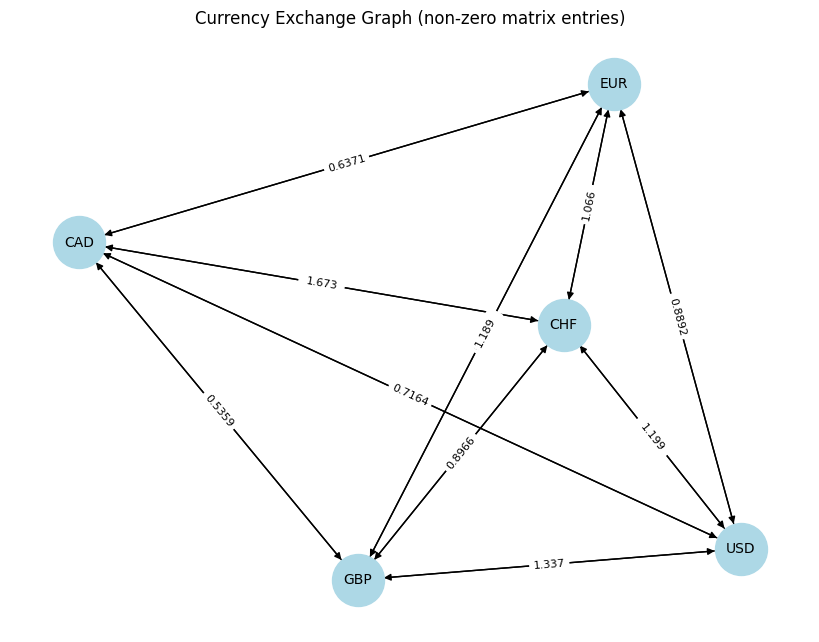

In [29]:
pos = nx.spring_layout(G, seed=42)
plt.figure()
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=1400, font_size=10)
labels = nx.get_edge_attributes(G, "weight")
labels = {k: f"{v:.4g}" for k, v in labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)
plt.title("Currency Exchange Graph (non-zero matrix entries)")
plt.show()

## 2.6 Build the QUBO (position-based, fixed cycle length)

We build a QUBO over variables `x[p,i]` that encodes a directed cycle of length `L`.

### Objective (maximize product of rates)

A cycle `(c_0 → c_1 → ... → c_{L-1} → c_0)` has gross return:

- `Π_{p=0..L-1} R[c_p, c_{(p+1) mod L}]`

We maximize this by minimizing the negative log-return:

- `min Σ_{p} -log(R[c_p, c_{p+1}])`

This becomes **quadratic** in `x[p,i] x[p+1,j]`.

### Constraints (as penalties)

- **One currency per position**: for each `p`, `Σ_i x[p,i] = 1`
- **No repeated currency**: for each currency `i`, it may appear in at most one position.
- **No invalid transitions**: if `R[i,j]=0` (no edge), selecting `i` then `j` is penalized.

In [30]:
penalty_position = 50.0
penalty_repeat = 50.0
penalty_invalid_edge = 200.0

linear = {v: 0.0 for v in var_names}
quadratic = {}
constant = 0.0

def _add_q(a, b, coeff):
    if a == b:
        linear[a] += coeff
        return
    key = (a, b) if a < b else (b, a)
    quadratic[key] = quadratic.get(key, 0.0) + float(coeff)

# Objective + invalid-edge penalties: transitions between consecutive positions (including last->first)
for p in range(trading_cycle_length):
    q = (p + 1) % trading_cycle_length
    for i, u in enumerate(currencies):
        for j, v in enumerate(currencies):
            a = f"x_{p}_{i}"
            b = f"x_{q}_{j}"
            if i == j:
                _add_q(a, b, penalty_invalid_edge)
                continue
            rate = float(R[i, j])
            if rate <= 0:
                _add_q(a, b, penalty_invalid_edge)
            else:
                _add_q(a, b, -math.log(rate))

# Constraint: exactly one currency at each position p -> (sum_i x[p,i] - 1)^2
for p in range(trading_cycle_length):
    vars_p = [f"x_{p}_{i}" for i in range(number_of_currencies)]
    for v in vars_p:
        linear[v] += -penalty_position
    for a_idx in range(len(vars_p)):
        for b_idx in range(a_idx + 1, len(vars_p)):
            _add_q(vars_p[a_idx], vars_p[b_idx], 2.0 * penalty_position)
    constant += penalty_position

# Constraint: each currency appears at most once (pairwise penalty across positions)
for i in range(number_of_currencies):
    vars_i = [f"x_{p}_{i}" for p in range(trading_cycle_length)]
    for a_idx in range(len(vars_i)):
        for b_idx in range(a_idx + 1, len(vars_i)):
            _add_q(vars_i[a_idx], vars_i[b_idx], penalty_repeat)

print("QUBO built for N x L variables:", num_variables)
print("penalty_position=", penalty_position, "penalty_repeat=", penalty_repeat, "penalty_invalid_edge=", penalty_invalid_edge)
print("Quadratic terms:", len(quadratic), "Constant:", constant)

QUBO built for N x L variables: 15
penalty_position= 50.0 penalty_repeat= 50.0 penalty_invalid_edge= 200.0
Quadratic terms: 105 Constant: 150.0


## 2.7 Create the QUBO model

We now create a `QuadraticProgram` with `N×L` binary variables and attach the QUBO objective (including penalties).

This `QuadraticProgram` is then converted to an Ising Hamiltonian for QAOA.

In [31]:
qp = QuadraticProgram()
for v in var_names:
    qp.binary_var(name=v)

qp.minimize(constant=constant, linear=linear, quadratic=quadratic)

print(qp.prettyprint())

Problem name: 

Minimize
  100*x_0_0*x_0_1 + 100*x_0_0*x_0_2 + 100*x_0_0*x_0_3 + 100*x_0_0*x_0_4
  + 250*x_0_0*x_1_0 - 0.1173118135375669*x_0_0*x_1_1
  + 0.1729733874016338*x_0_0*x_1_2 - 0.45068063690631777*x_0_0*x_1_3
  + 0.06400532997591243*x_0_0*x_1_4 + 250*x_0_0*x_2_0
  + 0.11746683565287404*x_0_0*x_2_1 - 0.17279297032745222*x_0_0*x_2_2
  + 0.45089143632295375*x_0_0*x_2_3 - 0.0637913670874861*x_0_0*x_2_4
  + 100*x_0_1*x_0_2 + 100*x_0_1*x_0_3 + 100*x_0_1*x_0_4
  + 0.11746683565287404*x_0_1*x_1_0 + 250*x_0_1*x_1_1
  + 0.2903523010076598*x_0_1*x_1_2 - 0.3334032463703034*x_0_1*x_1_3
  + 0.18137800208174223*x_0_1*x_1_4 - 0.1173118135375669*x_0_1*x_2_0
  + 250*x_0_1*x_2_1 - 0.29019640885710984*x_0_1*x_2_2
  + 0.333544526549878*x_0_1*x_2_3 - 0.18122095134992158*x_0_1*x_2_4
  + 100*x_0_2*x_0_3 + 100*x_0_2*x_0_4 - 0.17279297032745222*x_0_2*x_1_0
  - 0.29019640885710984*x_0_2*x_1_1 + 250*x_0_2*x_1_2
  - 0.6235237531715426*x_0_2*x_1_3 - 0.10886337348172986*x_0_2*x_1_4
  + 0.1729733874016338*x

# 3. QAOA formulation and execution

This section converts the QUBO into an **Ising Hamiltonian** and constructs a **QAOA ansatz circuit**.

At a high level, QAOA alternates between:

- **Problem unitary** derived from the Ising Hamiltonian (parameterized by `γ`)
- **Mixer unitary** (typically X-rotations, parameterized by `β`)

Measured bitstrings correspond to candidate edge selections, which we later validate and analyze.


## 3.1 Convert QUBO to an Ising Hamiltonian

Use Qiskit Optimization utilities to convert the QUBO into an Ising operator (`SparsePauliOp`) plus an energy offset.

This operator is the input to QAOA.

In [32]:
qubo_converter = QuadraticProgramToQubo()
qubo = qubo_converter.convert(qp)
ising_op, offset = qubo.to_ising()
print("Ising Hamiltonian:")
print(ising_op)
print(f"Ising constant offset: {offset:.4f}")

Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIZI', 'IIIIIIIIIIIIZII', 'IIIIIIIIIIIZIII', 'IIIIIIIIIIZIIII', 'IIIIIIIIIZIIIII', 'IIIIIIIIZIIIIII', 'IIIIIIIZIIIIIII', 'IIIIIIZIIIIIIII', 'IIIIIZIIIIIIIII', 'IIIIZIIIIIIIIII', 'IIIZIIIIIIIIIII', 'IIZIIIIIIIIIIII', 'IZIIIIIIIIIIIII', 'ZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIZIZ', 'IIIIIIIIIIIZIIZ', 'IIIIIIIIIIZIIIZ', 'IIIIIIIIIZIIIIZ', 'IIIIIIIIZIIIIIZ', 'IIIIIIIZIIIIIIZ', 'IIIIIIZIIIIIIIZ', 'IIIIIZIIIIIIIIZ', 'IIIIZIIIIIIIIIZ', 'IIIZIIIIIIIIIIZ', 'IIZIIIIIIIIIIIZ', 'IZIIIIIIIIIIIIZ', 'ZIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIZZI', 'IIIIIIIIIIIZIZI', 'IIIIIIIIIIZIIZI', 'IIIIIIIIIZIIIZI', 'IIIIIIIIZIIIIZI', 'IIIIIIIZIIIIIZI', 'IIIIIIZIIIIIIZI', 'IIIIIZIIIIIIIZI', 'IIIIZIIIIIIIIZI', 'IIIZIIIIIIIIIZI', 'IIZIIIIIIIIIIZI', 'IZIIIIIIIIIIIZI', 'ZIIIIIIIIIIIIZI', 'IIIIIIIIIIIZZII', 'IIIIIIIIIIZIZII', 'IIIIIIIIIZIIZII', 'IIIIIIIIZIIIZII', 'IIIIIIIZIIIIZII', 'IIIIIIZIIIIIZII', 'IIIIIZIIIIIIZII', 'IIIIZIIIIIIIZII', 'IIIZIIIIIIIIZII

## 3.2 QAOA execution

We follow the team-lead QAOA procedure:

1. **Start Everywhere**: initialize all qubits in superposition.
2. **Twist for Profit**: apply the cost unitary from the Ising Hamiltonian.
3. **Shake it Up**: apply the mixer unitary.
4. **Check Signal**: measure and sample bitstrings.
5. **Tune Again**: use a classical optimizer (COBYLA) to tune parameters.
6. **Pick Winner**: pick the best feasible cycle from the sampled bitstrings.

In [33]:
reps = 2
shots = 2048
maxiter = 60

ansatz = QAOAAnsatz(ising_op, reps=reps)
qc = ansatz.decompose().copy()
qc.measure_all()

_default_backend_qubit_limit = AerSimulator().configuration().n_qubits
_backend_options = {}
if num_variables > _default_backend_qubit_limit:
    _backend_options["method"] = "matrix_product_state"

if _backend_options:
    sampler = SamplerV2(options={"backend_options": _backend_options})
else:
    sampler = SamplerV2()

qc = transpile(qc, optimization_level=1)
param_list = list(qc.parameters)

neglog = np.full((number_of_currencies, number_of_currencies), np.inf, dtype=float)
for i in range(number_of_currencies):
    for j in range(number_of_currencies):
        if i == j:
            continue
        if R[i, j] > 0:
            neglog[i, j] = -math.log(float(R[i, j]))


def _bitstr_le(bitstr):
    bitstr = bitstr.replace(" ", "")
    if len(bitstr) != num_variables:
        raise ValueError(f"Expected bitstring length {num_variables}, got {len(bitstr)}")
    return bitstr[::-1]


def qubo_energy_from_bitstr(bitstr):
    b = _bitstr_le(bitstr)
    x = {v: int(b[k]) for k, v in enumerate(var_names)}
    e = constant
    for v, c in linear.items():
        e += c * x[v]
    for (a, bname), c in quadratic.items():
        e += c * x[a] * x[bname]
    return float(e)


def decode_cycle(bitstr):
    b = _bitstr_le(bitstr)

    chosen = [-1] * trading_cycle_length
    used = set()

    for p in range(trading_cycle_length):
        ones = []
        for i in range(number_of_currencies):
            k = p * number_of_currencies + i
            if b[k] == "1":
                ones.append(i)
        if len(ones) != 1:
            return None
        i = ones[0]
        if i in used:
            return None
        used.add(i)
        chosen[p] = i

    for p in range(trading_cycle_length):
        i = chosen[p]
        j = chosen[(p + 1) % trading_cycle_length]
        if not np.isfinite(neglog[i, j]):
            return None

    return chosen


def cycle_returns(cycle_idx):
    log_ret = 0.0
    gross = 1.0
    for p in range(trading_cycle_length):
        i = cycle_idx[p]
        j = cycle_idx[(p + 1) % trading_cycle_length]
        r = float(R[i, j])
        gross *= r
        log_ret += math.log(r)
    return gross, log_ret


def sample_probs(theta, shots_local):
    theta_vals = np.array(theta, dtype=float).reshape(-1)
    if theta_vals.size != len(param_list):
        raise ValueError(f"Parameter length mismatch: expected {len(param_list)}, got {theta_vals.size}")
    binding = {p: float(theta_vals[i]) for i, p in enumerate(param_list)}
    job = sampler.run([(qc, binding)], shots=int(shots_local))
    raw = job.result()
    counts = raw[0].data.meas.get_counts()
    return {b.replace(" ", ""): c / int(shots_local) for b, c in counts.items()}


import time
_state = {"eval": 0, "t0": time.perf_counter()}
shots_opt = int(min(shots, 256) if num_variables > 25 else shots)


def expected_energy(theta):
    _state["eval"] += 1

    probs_local = sample_probs(theta, shots_opt)
    e = sum(p * qubo_energy_from_bitstr(b) for b, p in probs_local.items())

    if _state["eval"] == 1 or _state["eval"] % 5 == 0:
        elapsed = time.perf_counter() - _state["t0"]
        avg = elapsed / max(1, _state["eval"])
        remaining = max(0, maxiter - _state["eval"])
        eta = remaining * avg
        print(
            f"eval={_state['eval']}/{maxiter}  elapsed={elapsed:.1f}s  avg/eval={avg:.2f}s  ETA~{eta/60:.1f} min  shots_opt={shots_opt}"
        )

    return float(e)


x0 = np.zeros(len(param_list), dtype=float)

opt = COBYLA(maxiter=maxiter)
opt_result = opt.minimize(fun=expected_energy, x0=x0)

best_theta = np.array(opt_result.x, dtype=float)

probs = sample_probs(best_theta, shots)

sorted_samples = sorted(probs.items(), key=lambda kv: kv[1], reverse=True)
samples_num_variables = num_variables

most_prob_cycle = None
most_prob_bstr = None
most_prob_prob = None
most_prob_gross = None
most_prob_log_ret = None

for bstr, p in sorted_samples[:500]:
    if len(bstr) != num_variables:
        continue
    cyc = decode_cycle(bstr)
    if cyc is None:
        continue
    gross, log_ret = cycle_returns(cyc)
    most_prob_cycle = cyc
    most_prob_bstr = bstr
    most_prob_prob = p
    most_prob_gross = gross
    most_prob_log_ret = log_ret
    break

best_profit_cycle = None
best_profit_bstr = None
best_profit_prob = None
best_profit_gross = -float("inf")
best_profit_log_ret = None

for bstr, p in sorted_samples[:500]:
    if len(bstr) != num_variables:
        continue
    cyc = decode_cycle(bstr)
    if cyc is None:
        continue
    gross, log_ret = cycle_returns(cyc)
    if gross > best_profit_gross:
        best_profit_gross = gross
        best_profit_cycle = cyc
        best_profit_bstr = bstr
        best_profit_prob = p
        best_profit_log_ret = log_ret

if best_profit_cycle is not None:
    best_cycle = best_profit_cycle
    best_bstr = best_profit_bstr
    best_prob = best_profit_prob
    best_gross = best_profit_gross
    best_log_ret = best_profit_log_ret
else:
    best_cycle = most_prob_cycle
    best_bstr = most_prob_bstr
    best_prob = most_prob_prob
    best_gross = most_prob_gross
    best_log_ret = most_prob_log_ret

if best_cycle is None:
    if sorted_samples:
        best_bstr = sorted_samples[0][0]
    print("No feasible cycle found in the sampled bitstrings. Try increasing shots/maxiter or adjusting penalties.")
else:
    cycle_currencies = [currencies[i] for i in best_cycle]
    print("Optimized feasible cycle (max profit among sampled, length L):", " → ".join(cycle_currencies + [cycle_currencies[0]]))
    print("Sample probability (approx):", best_prob)
    print("Gross return:", best_gross)
    print("Log-return:", best_log_ret)

    if most_prob_cycle is not None and most_prob_cycle != best_cycle:
        cycle_currencies_2 = [currencies[i] for i in most_prob_cycle]
        print("Most-probable feasible sampled cycle:", " → ".join(cycle_currencies_2 + [cycle_currencies_2[0]]))
        print("Sample probability (approx):", most_prob_prob)
        print("Gross return:", most_prob_gross)
        print("Log-return:", most_prob_log_ret)


eval=1/60  elapsed=0.2s  avg/eval=0.21s  ETA~0.2 min  shots_opt=2048
eval=5/60  elapsed=1.0s  avg/eval=0.20s  ETA~0.2 min  shots_opt=2048
eval=10/60  elapsed=1.9s  avg/eval=0.19s  ETA~0.2 min  shots_opt=2048
eval=15/60  elapsed=2.9s  avg/eval=0.19s  ETA~0.1 min  shots_opt=2048
eval=20/60  elapsed=3.8s  avg/eval=0.19s  ETA~0.1 min  shots_opt=2048
eval=25/60  elapsed=4.7s  avg/eval=0.19s  ETA~0.1 min  shots_opt=2048
eval=30/60  elapsed=5.5s  avg/eval=0.18s  ETA~0.1 min  shots_opt=2048
eval=35/60  elapsed=6.3s  avg/eval=0.18s  ETA~0.1 min  shots_opt=2048
eval=40/60  elapsed=7.1s  avg/eval=0.18s  ETA~0.1 min  shots_opt=2048
Optimized feasible cycle (max profit among sampled, length L): USD → CAD → GBP → USD
Sample probability (approx): 0.001953125
Gross return: 0.9998665996504058
Log-return: -0.00013340924821214628
Most-probable feasible sampled cycle: CAD → GBP → EUR → CAD
Sample probability (approx): 0.001953125
Gross return: 0.999740576414264
Log-return: -0.00025945724185538754


## 3.3 QAOA circuit resource estimates

We report:

- Qubit count = number of binary variables (`N×L`)
- Circuit depth and gate count (for the decomposed ansatz, excluding measurement)

In [34]:
decomposed = ansatz.decompose()
print("Qubits:", num_variables)
print("QAOA reps:", reps)
print("Circuit depth (no measurement):", decomposed.depth())
print("Total gates (no measurement):", decomposed.size())

Qubits: 15
QAOA reps: 2
Circuit depth (no measurement): 5
Total gates (no measurement): 19


## 3.4 Notes on feasibility

The QUBO penalties enforce feasibility, but sampling noise can still produce infeasible bitstrings.

The winner selection step explicitly filters to the first **feasible** length-`L` directed cycle among the high-probability samples.

In [35]:
print("Top-10 sampled bitstrings (probability):")
for b, p in sorted_samples[:10]:
    print(b, p)

Top-10 sampled bitstrings (probability):
000000000000000 0.03515625
001000000000000 0.00927734375
000000100000000 0.0087890625
010000000010000 0.00830078125
000000010001000 0.00830078125
000000000010000 0.00830078125
000100000000000 0.0078125
000000000001000 0.0078125
000000000000100 0.0078125
010000000000100 0.0078125


## 3.5 Decode the chosen cycle into edges and validate

We convert the chosen cycle into directed edges and verify that each edge exists in the rate matrix.

In [36]:
if best_cycle is None:
    selected_edges = []
else:
    selected_edges = []
    for p in range(trading_cycle_length):
        u = currencies[best_cycle[p]]
        v = currencies[best_cycle[(p + 1) % trading_cycle_length]]
        selected_edges.append((u, v))

print("Selected edges (cycle):", selected_edges)

Selected edges (cycle): [('USD', 'CAD'), ('CAD', 'GBP'), ('GBP', 'USD')]


# 4. Validation and baselines

This section validates the decoded **length-`L` cycle** returned by QAOA and compares it to a small classical baseline when the instance size is small enough.

## 4.1 Validate the QAOA-selected cycle

We validate:

- The cycle contains exactly `L` distinct currencies.
- Every transition exists (`R[i,j] > 0`).
- We report gross return and log-return.

In [37]:
if best_cycle is None:
    print("No feasible cycle was found. Run Section 3.2 with higher shots/maxiter or adjusted penalties.")
else:
    cycle_currencies = [currencies[i] for i in best_cycle]

    ok_unique = (len(set(best_cycle)) == trading_cycle_length)

    ok_edges = True
    for p in range(trading_cycle_length):
        i = best_cycle[p]
        j = best_cycle[(p + 1) % trading_cycle_length]
        if float(R[i, j]) <= 0:
            ok_edges = False
            break

    gross, log_ret = cycle_returns(best_cycle)

    print("Cycle:", " → ".join(cycle_currencies + [cycle_currencies[0]]))
    print("Unique currencies:", ok_unique)
    print("All transitions exist:", ok_edges)
    print("Gross return:", gross)
    print("Log-return:", log_ret)
    print("Gross profit %:", (gross - 1.0) * 100.0)

Cycle: USD → CAD → GBP → USD
Unique currencies: True
All transitions exist: True
Gross return: 0.9998665996504058
Log-return: -0.00013340924821214628
Gross profit %: -0.013340034959419267


## 4.2 Classical baseline (brute force for fixed length `L`)

For small `N` and `L`, we can enumerate all length-`L` cycles (permutations of `L` distinct currencies) and compute the best gross return.

This is only a diagnostic baseline and is not intended to scale.

In [38]:
from itertools import permutations

N = number_of_currencies
L = trading_cycle_length

count = math.perm(N, L)
max_enum = 200000

if count > max_enum:
    print(f"Skipping brute force: permutations={count} exceeds limit={max_enum}")
else:
    best_perm = None
    best_g = -float("inf")

    for perm in permutations(range(N), L):
        feasible = True
        gross_val = 1.0
        for p in range(L):
            i = perm[p]
            j = perm[(p + 1) % L]
            r = float(R[i, j])
            if r <= 0:
                feasible = False
                break
            gross_val *= r
        if not feasible:
            continue
        if gross_val > best_g:
            best_g = gross_val
            best_perm = perm

    if best_perm is None:
        print("No feasible length-L cycle exists under the non-zero matrix entries.")
    else:
        cyc = [currencies[i] for i in best_perm]
        print("Best classical length-L cycle:", " → ".join(cyc + [cyc[0]]))
        print("Best classical gross return:", best_g)
        print("Best classical gross profit %:", (best_g - 1.0) * 100.0)
        print("QAOA gross return:", best_gross)

Best classical length-L cycle: GBP → USD → CAD → GBP
Best classical gross return: 0.9998665996504059
Best classical gross profit %: -0.013340034959408165
QAOA gross return: 0.9998665996504058


## 4.3 Penalty tuning note

If no feasible cycle is found, typical fixes are:

- Increase `penalty_invalid_edge` (forbids missing edges more strongly)
- Increase `penalty_position` / `penalty_repeat` (enforces constraints more strongly)
- Increase `shots` (reduces sampling noise)
- Increase `maxiter` (more classical tuning steps)

In [39]:
print("Current penalties:")
print("penalty_position =", penalty_position)
print("penalty_repeat =", penalty_repeat)
print("penalty_invalid_edge =", penalty_invalid_edge)
print("If you change these, re-run Sections 2.6–3.2.")

Current penalties:
penalty_position = 50.0
penalty_repeat = 50.0
penalty_invalid_edge = 200.0
If you change these, re-run Sections 2.6–3.2.


## 4.4 Inspect feasible samples

We list a few feasible cycles discovered among the high-probability sampled bitstrings.

In [40]:
if "sorted_samples" not in globals() or "decode_cycle" not in globals() or "cycle_returns" not in globals():
    raise RuntimeError("Missing QAOA outputs. Re-run Section 3.2 (QAOA execution) first.")

if "samples_num_variables" not in globals() or samples_num_variables != num_variables:
    raise RuntimeError(
        "Stale sample list detected: bitstring size does not match current N×L. "
        "Re-run Section 3.2 (QAOA execution) to regenerate samples."
    )

shown = 0
for bstr, p in sorted_samples[:500]:
    if len(bstr.replace(" ", "")) != num_variables:
        continue
    cyc = decode_cycle(bstr)
    if cyc is None:
        continue
    gross_val, log_val = cycle_returns(cyc)
    cyc_names = [currencies[i] for i in cyc]
    print(f"p={p:.6f}  gross={gross_val:.6f}  cycle={' → '.join(cyc_names + [cyc_names[0]])}")
    shown += 1
    if shown >= 10:
        break

if shown == 0:
    print("No feasible cycles found among the top sampled bitstrings.")


p=0.001953  gross=0.999741  cycle=CAD → GBP → EUR → CAD
p=0.001953  gross=0.999824  cycle=USD → CAD → EUR → USD
p=0.001953  gross=0.999867  cycle=USD → CAD → GBP → USD
p=0.001953  gross=0.999725  cycle=EUR → USD → CHF → EUR
p=0.001465  gross=0.999753  cycle=GBP → EUR → USD → GBP
p=0.001465  gross=0.999756  cycle=USD → EUR → GBP → USD
p=0.001465  gross=0.999550  cycle=CHF → GBP → CAD → CHF
p=0.000977  gross=0.999483  cycle=EUR → CHF → CAD → EUR
p=0.000977  gross=0.999756  cycle=EUR → GBP → USD → EUR
p=0.000977  gross=0.999669  cycle=EUR → CAD → USD → EUR


# 5. Results and interpretation

This section summarizes the selected arbitrage cycle, provides fee sensitivity, simple cycle enumeration (when feasible), and a final visualization.

## 5.1 Final QAOA result (cycle + return)

We report the final selected length-`L` cycle and its return metrics.

In [41]:
if best_cycle is None:
    cycle_currencies = []
    gross = None
    log_ret = None
    print("No feasible cycle available to report.")
else:
    cycle_currencies = [currencies[i] for i in best_cycle]
    gross, log_ret = cycle_returns(best_cycle)

    print("Selected length-L cycle:")
    print(" → ".join(cycle_currencies + [cycle_currencies[0]]))
    print("Gross return:", gross)
    print("Gross profit %:", (gross - 1.0) * 100.0)
    print("Log-return:", log_ret)

Selected length-L cycle:
USD → CAD → GBP → USD
Gross return: 0.9998665996504058
Gross profit %: -0.013340034959419267
Log-return: -0.00013340924821214628


## 5.2 Fee sensitivity

Assume a constant per-trade fee `f` (e.g., 0.25% = 0.0025). For a length-`L` cycle, the net return is:

- `gross_net = gross * (1 - f)^L`

We also compute the break-even fee (where net return = 1).

In [42]:
def net_return_for_fee(gross_return, fee, L):
    return gross_return * ((1.0 - fee) ** L)


def breakeven_fee(gross_return, L):
    if gross_return is None:
        return None
    if gross_return <= 0:
        return None
    if gross_return <= 1.0:
        return 0.0
    return 1.0 - (1.0 / gross_return) ** (1.0 / L)


if gross is None:
    print("Skipping fee sensitivity: no feasible cycle.")
else:
    fees = [0.0, 0.001, 0.0025, 0.005, 0.01]

    print("Fee sensitivity (per trade):")
    for f in fees:
        net = net_return_for_fee(gross, f, trading_cycle_length)
        print(f"fee {f:.3%}: net_return={net:.6f}  net_profit%={(net-1.0)*100:.4f}")

    f_star = breakeven_fee(gross, trading_cycle_length)
    print("Break-even fee per trade:", f_star)

Fee sensitivity (per trade):
fee 0.000%: net_return=0.999867  net_profit%=-0.0133
fee 0.100%: net_return=0.996870  net_profit%=-0.3130
fee 0.250%: net_return=0.992386  net_profit%=-0.7614
fee 0.500%: net_return=0.984943  net_profit%=-1.5057
fee 1.000%: net_return=0.970170  net_profit%=-2.9830
Break-even fee per trade: 0.0


## 5.3 Enumerate top profitable length-`L` cycles (reference)

When enumeration is feasible (same limit used earlier), we list the top profitable length-`L` cycles by gross return.

In [43]:
top_k = 10

count = math.perm(number_of_currencies, trading_cycle_length)
max_enum = 200000

if count > max_enum:
    print(f"Skipping enumeration: permutations={count} exceeds limit={max_enum}")
else:
    ranked = []
    for perm in permutations(range(number_of_currencies), trading_cycle_length):
        feasible = True
        gross_val = 1.0
        for p in range(trading_cycle_length):
            i = perm[p]
            j = perm[(p + 1) % trading_cycle_length]
            r = float(R[i, j])
            if r <= 0:
                feasible = False
                break
            gross_val *= r
        if not feasible:
            continue
        if gross_val > 1.0:
            ranked.append((gross_val, perm))

    ranked.sort(key=lambda x: -x[0])
    if not ranked:
        print("No profitable length-L cycles found.")
    else:
        print(f"Top {min(top_k, len(ranked))} profitable length-L cycles:")
        for gross_val, perm in ranked[:top_k]:
            cyc = [currencies[i] for i in perm]
            print(f"gross={gross_val:.6f}  profit%={(gross_val-1.0)*100:.4f}  cycle={' → '.join(cyc + [cyc[0]])}")

No profitable length-L cycles found.


## 5.4 QUBO energy diagnostics

We compute the QUBO energy of the selected cycle bitstring for debugging and comparison.

In [44]:
def cycle_to_bitstr(cycle_idx):
    bits_le = ["0"] * num_variables
    for p, i in enumerate(cycle_idx):
        k = p * number_of_currencies + i
        bits_le[k] = "1"
    return "".join(bits_le[::-1])

if best_cycle is None:
    print("Skipping QUBO energy diagnostic: no feasible cycle.")
else:
    cycle_bitstr = cycle_to_bitstr(best_cycle)
    print("Cycle bitstring:", cycle_bitstr)
    print("QUBO energy of cycle:", qubo_energy_from_bitstr(cycle_bitstr))

Cycle bitstring: 001000100000010
QUBO energy of cycle: 0.00013340924821214628


## 5.5 Fee example

A single example net-return calculation for a chosen fee.

In [45]:
example_fee = 0.0025

if gross is None:
    print("Skipping fee example: no feasible cycle.")
else:
    net = net_return_for_fee(gross, example_fee, trading_cycle_length)
    print("Example fee:", example_fee)
    print("Net return:", net)
    print("Net profit %:", (net - 1.0) * 100.0)

Example fee: 0.0025
Net return: 0.9923863320288557
Net profit %: -0.7613667971144267


In [46]:
fees = [0.0, 0.001, 0.002, 0.005, 0.01]

if gross is None:
    print("Skipping fee sweep: no feasible cycle.")
else:
    for f in fees:
        net = net_return_for_fee(gross, f, trading_cycle_length)
        print(f"fee {f:.3%}: net profit {(net-1.0):.6f} ({(net-1.0)*100:.4f}%)")

fee 0.000%: net profit -0.000133 (-0.0133%)
fee 0.100%: net profit -0.003130 (-0.3130%)
fee 0.200%: net profit -0.006121 (-0.6121%)
fee 0.500%: net profit -0.015057 (-1.5057%)
fee 1.000%: net profit -0.029830 (-2.9830%)


## 5.6 Helper: cycle edges and labels

We build an edge list for the selected cycle to use in the final plot.

In [47]:
if best_cycle is None:
    cycle_edges = []
    print("Skipping cycle edges: no feasible cycle.")
else:
    cycle_edges = [(cycle_currencies[p], cycle_currencies[(p + 1) % trading_cycle_length]) for p in range(trading_cycle_length)]
    print("Cycle edges:", cycle_edges)

Cycle edges: [('USD', 'CAD'), ('CAD', 'GBP'), ('GBP', 'USD')]


In [48]:
if not cycle_edges:
    print("No cycle edges to validate in graph.")
else:
    print("Edges exist in graph:")
    for u, v in cycle_edges:
        print(u, "->", v, "rate=", G[u][v]["weight"] if G.has_edge(u, v) else None)

Edges exist in graph:
USD -> CAD rate= 1.39571
CAD -> GBP rate= 0.53594
GBP -> USD rate= 1.33669


## 5.7 Visualize the selected arbitrage cycle

We plot the exchange graph and highlight the selected cycle edges in red.

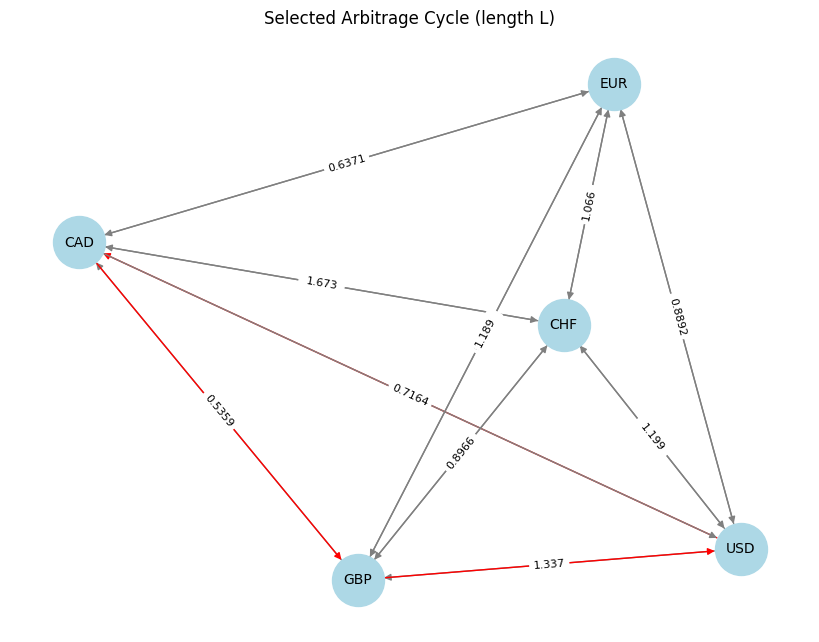

In [49]:
if not cycle_edges:
    print("Skipping plot: no feasible cycle.")
else:
    edge_colors = []
    for e in G.edges():
        edge_colors.append("red" if e in cycle_edges else "gray")

    plt.figure()
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=1400, font_size=10, edge_color=edge_colors)
    labels = nx.get_edge_attributes(G, "weight")
    labels = {k: f"{v:.4g}" for k, v in labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)
    plt.title("Selected Arbitrage Cycle (length L)")
    plt.show()